# **Implementation of a scoring model**
## **Notebook 1/6 - Exploratory Analysis**



This notebook is organized as follows:

**0. Set up**
- 0.1 Loading libraries and useful functions
- 0.2 Loading and description of the dataset

**1. Exploratory analysis**
- 1.1 Missing values
- 1.2 Distributions
    * 1.2.1 Quantitative characteristics
    * 1.2.2 Qualitative Features
    * 1.2.3 Loan repayment
- 1.3 Anomalies
- 1.4 Correlations with TARGET default risk
    * 1.4.1 Strongest correlations
    * 1.4.2 Focus: correlation with seniority in current position DAYS_EMPLOYED
    * 1.4.2 Focus: correlation with age DAYS_BIRTH
    * 1.4.3 Focus: correlation with the synthetic indicators EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3
    
**2. Conclusion**

___
### 0. SETUP

In this first step, the working framework is put in place, that is to say:
- The necessary Python libraries and packages are loaded
- Useful functions are defined
- The dataset is loaded
___

___
#### 0.1 LOADING LIBRARIES AND USEFUL FUNCTIONS

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
from sys import path
path.append("./Resources/functions")

import helper_functions as hf
import graphical_functions as gf

___
#### 0.2 LOADING AND DESCRIPTION OF THE DATASET

In [3]:
app_train = pd.read_csv("./Resources/datasets/origin/application_train.csv")

app_test = pd.read_csv("./Resources/datasets/origin/application_test.csv")

bureau_balance = pd.read_csv("./Resources/datasets/origin/bureau_balance.csv")

bureau = pd.read_csv("./Resources/datasets/origin/bureau.csv")

credit = pd.read_csv("./Resources/datasets/origin/credit_card_balance.csv")

installments = pd.read_csv("./Resources/datasets/origin/installments_payments.csv")

cash = pd.read_csv("./Resources/datasets/origin/POS_CASH_balance.csv")

prev_app = pd.read_csv("./Resources/datasets/origin/previous_application.csv")

In [4]:
hf.describe_dataset({'App Train':app_train,
                     'App Test': app_test, 
                     'Bureau': bureau,
                     'Bureau Balance': bureau_balance,
                     'Credit Card Balance:' : credit,
                     'Installments Payments': installments,
                     'POS cash balance': cash,
                     'Previous App': prev_app})

The data is broken down into 8 file(s): 



Filename  Nb of lines  Nb of columns
1              App Train       307511            122
2               App Test        48744            121
3                 Bureau      1715874             17
4         Bureau Balance     27299925              3
5   Credit Card Balance:      3840312             23
6  Installments Payments     13605401              8
7       POS cash balance     10001358              8
8           Previous App      1670214             37

<table style="width:100%;align:'left'">
  <tr>
    <th>File</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>App Train</td>
    <td>Main training data. <br>One row represents one loan.
    </td> 
  </tr>
  
  <tr>
    <td>App Test</td>
    <td>Main testing data. <br> One row represents one loan.</td>
  </tr>
    
  <tr>
    <td>Bureau</td>
    <td>All client's previous credit from other financial institutions <br>
        for clients who have a loan in the sample.
    </td>
  </tr>
 
  <tr>
    <td>Bureau Balance</td>
    <td>Monthly balances of previous credits in bureau. <br>
        The table contains one row for each month of history of <br>
        every previous credit in bureau.
    </td> 
  </tr>

  <tr>
    <td>Credit Card Balance</td>
    <td>Monthly balance snapshots of previous cardit cards of the applicant.<br>
        The table contains one row for each month of history of every <br>
        previous credit in Home Credit (consumer credit and cash loans)<br>
        related to loans in our sample. 
    </td> 
  </tr>

  <tr>
    <td>Installments payments</td>
    <td>Repayment history for the previously disbursed credits related <br>
        to the loans in the sample.<br>
        The table contains :<br>
        - one row for every payment made
        - one row each for missed payment
        One row = one payment of one installment OR one installment <br>
        corresponding to one payment of one previous Home Credit related<br>
        to loans in our sample.
    </td> 
  </tr>
    
  <tr>
    <td>POS cash balance</td>
    <td>Monthly balance snapshots of previous POS and cash loans that <br>
        the applicant had.<br>
        The table contains one row for each month of history of every <br>
        previous credit in Home Credit (consumer credit and cash loans)<br>
        related to loans in our sample.
    </td> 
  </tr>

  <tr>
    <td>Previous App</td>
    <td>Previous applications for loans at Home Credit of clients <br>
        who have loans in the application data.<br>
        The table contains one row for each previous application<br>
        related to loans in the sample.
    </td> 
  </tr>
</table>

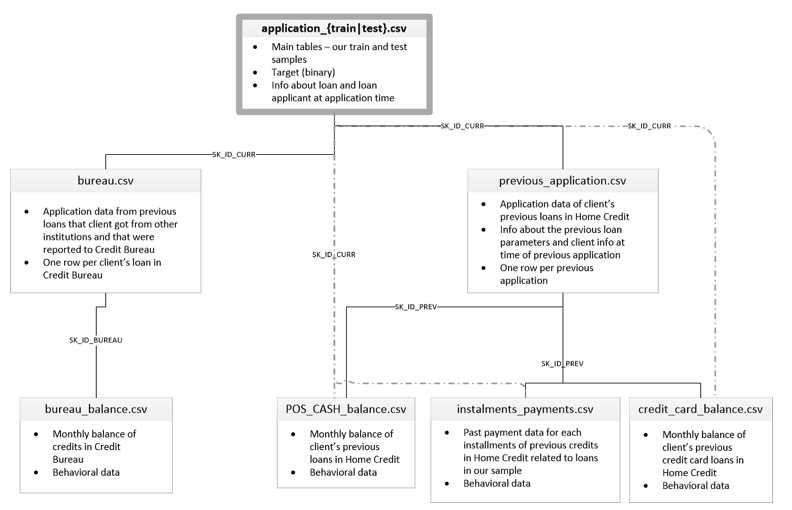

___
### 1. Exploratory Analysis
- Missing values
- The distribution of certain features of interest
- Any anomalies
- Correlations
___

In [5]:
interesting_cols_quant = ['AMT_ANNUITY',
                          'AMT_CREDIT',
                          'AMT_GOODS_PRICE',
                          'AMT_INCOME_TOTAL',
                          'CNT_CHILDREN',
                         'CNT_FAM_MEMBERS',
                         'DAYS_BIRTH',
                          'DAYS_EMPLOYED']

interesting_cols_qual = ['CNT_CHILDREN',
                         'CNT_FAM_MEMBERS',
                         'NAME_CONTRACT_TYPE',
                         'NAME_EDUCATION_TYPE',
                         'NAME_FAMILY_STATUS',
                         'NAME_HOUSING_TYPE',
                         'NAME_INCOME_TYPE',
                         'OCCUPATION_TYPE',
                         'ORGANIZATION_TYPE']     

interesting_cols = interesting_cols_quant + interesting_cols_qual                

___
#### 1.1 MISSING VALUES

In [6]:
missing_values_df = hf.get_missing_values_percent_per(app_train)\
                      .drop(columns=["Percent Filled", "Total"])\
                      .sort_values("Percent Missing", ascending=False)

In [7]:
print("{:2.2f}% of features contain more than 50% missing values"\
.format(len(missing_values_df[missing_values_df["Percent Missing"]>50])/len(missing_values_df)*100))

33.61% of features contain more than 50% missing values


In [8]:
gf.plot_percentage_missing_values_for(app_train, 50, 150)

c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  handle_plot_1.set_xticklabels(handle_plot_1.get_xticks(),
c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  handle_plot_1.set_yticklabels(ylabels, size=TICK_SIZE)
c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  handle_plot_2.set_xticklabels(handle_plot_2.get_xticks(),
c:\Users\Admin\Desktop\credit_s

c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  handle_plot_1.set_xticklabels(handle_plot_1.get_xticks(),
c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  handle_plot_1.set_yticklabels(ylabels, size=TICK_SIZE)
c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  handle_plot_2.set_xticklabels(handle_plot_2.get_xticks(),
c:\Users\Admin\Desktop\credit_s

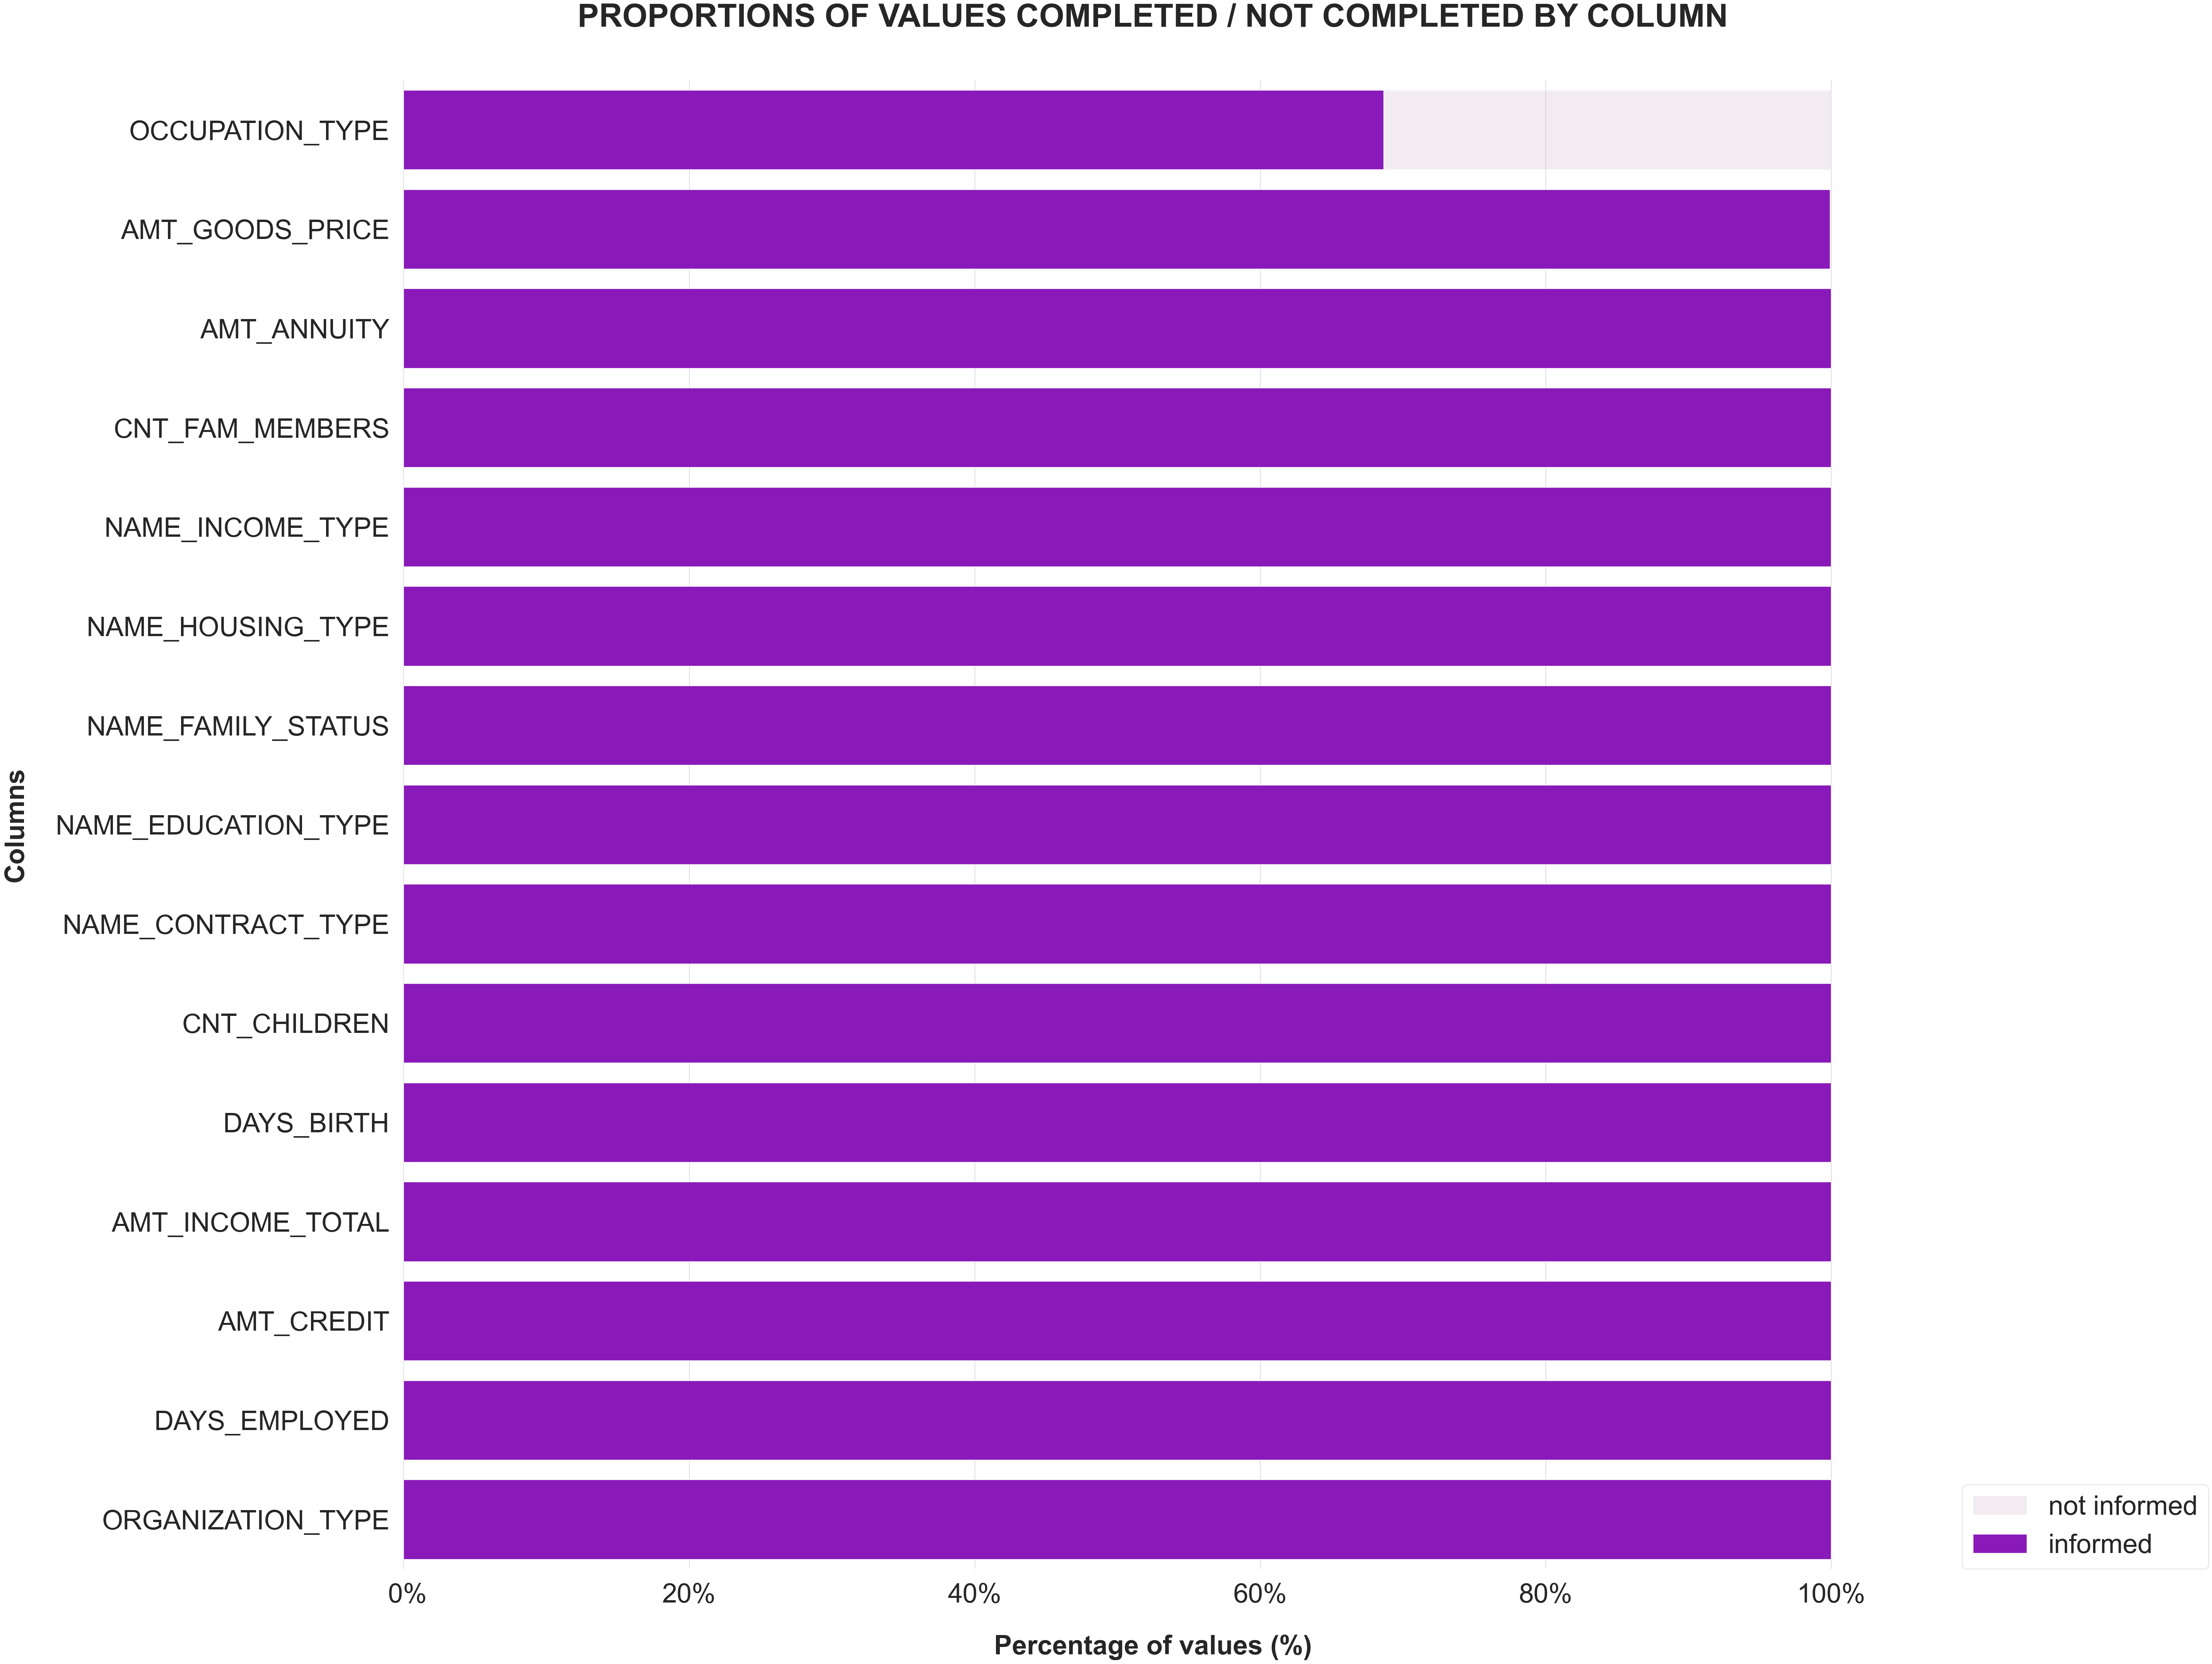

In [9]:
gf.plot_percentage_missing_values_for(app_train[interesting_cols], 50, 50)

___
#### 1.2 DISTRIBUTIONS

___
##### 1.2.1 _<u>Features quantitatives</u>_

In [10]:
pd.concat([app_train[interesting_cols_quant].mode().T.rename(columns={0:"Mode"}),
           app_train[interesting_cols_quant].median(),
           app_train[interesting_cols_quant].mean()], axis=1)\
  .rename(columns={0:"Median", 1:"Average"})

Mode    Median        Average
AMT_ANNUITY         9000.0   24903.0   27108.573909
AMT_CREDIT        450000.0  513531.0  599025.999706
AMT_GOODS_PRICE   450000.0  450000.0  538396.207429
AMT_INCOME_TOTAL  135000.0  147150.0  168797.919297
CNT_CHILDREN           0.0       0.0       0.417052
CNT_FAM_MEMBERS        2.0       2.0       2.152665
DAYS_BIRTH        -13749.0  -15750.0  -16036.995067
DAYS_EMPLOYED     365243.0   -1213.0   63815.045904

c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:275: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticks(), size=TICK_SIZE)
c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:275: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticks(), size=TICK_SIZE)
c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:275: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticks(), size=TICK_SIZE)
c:\Users\Admin\Desktop\credit_score_web_app-main\cre

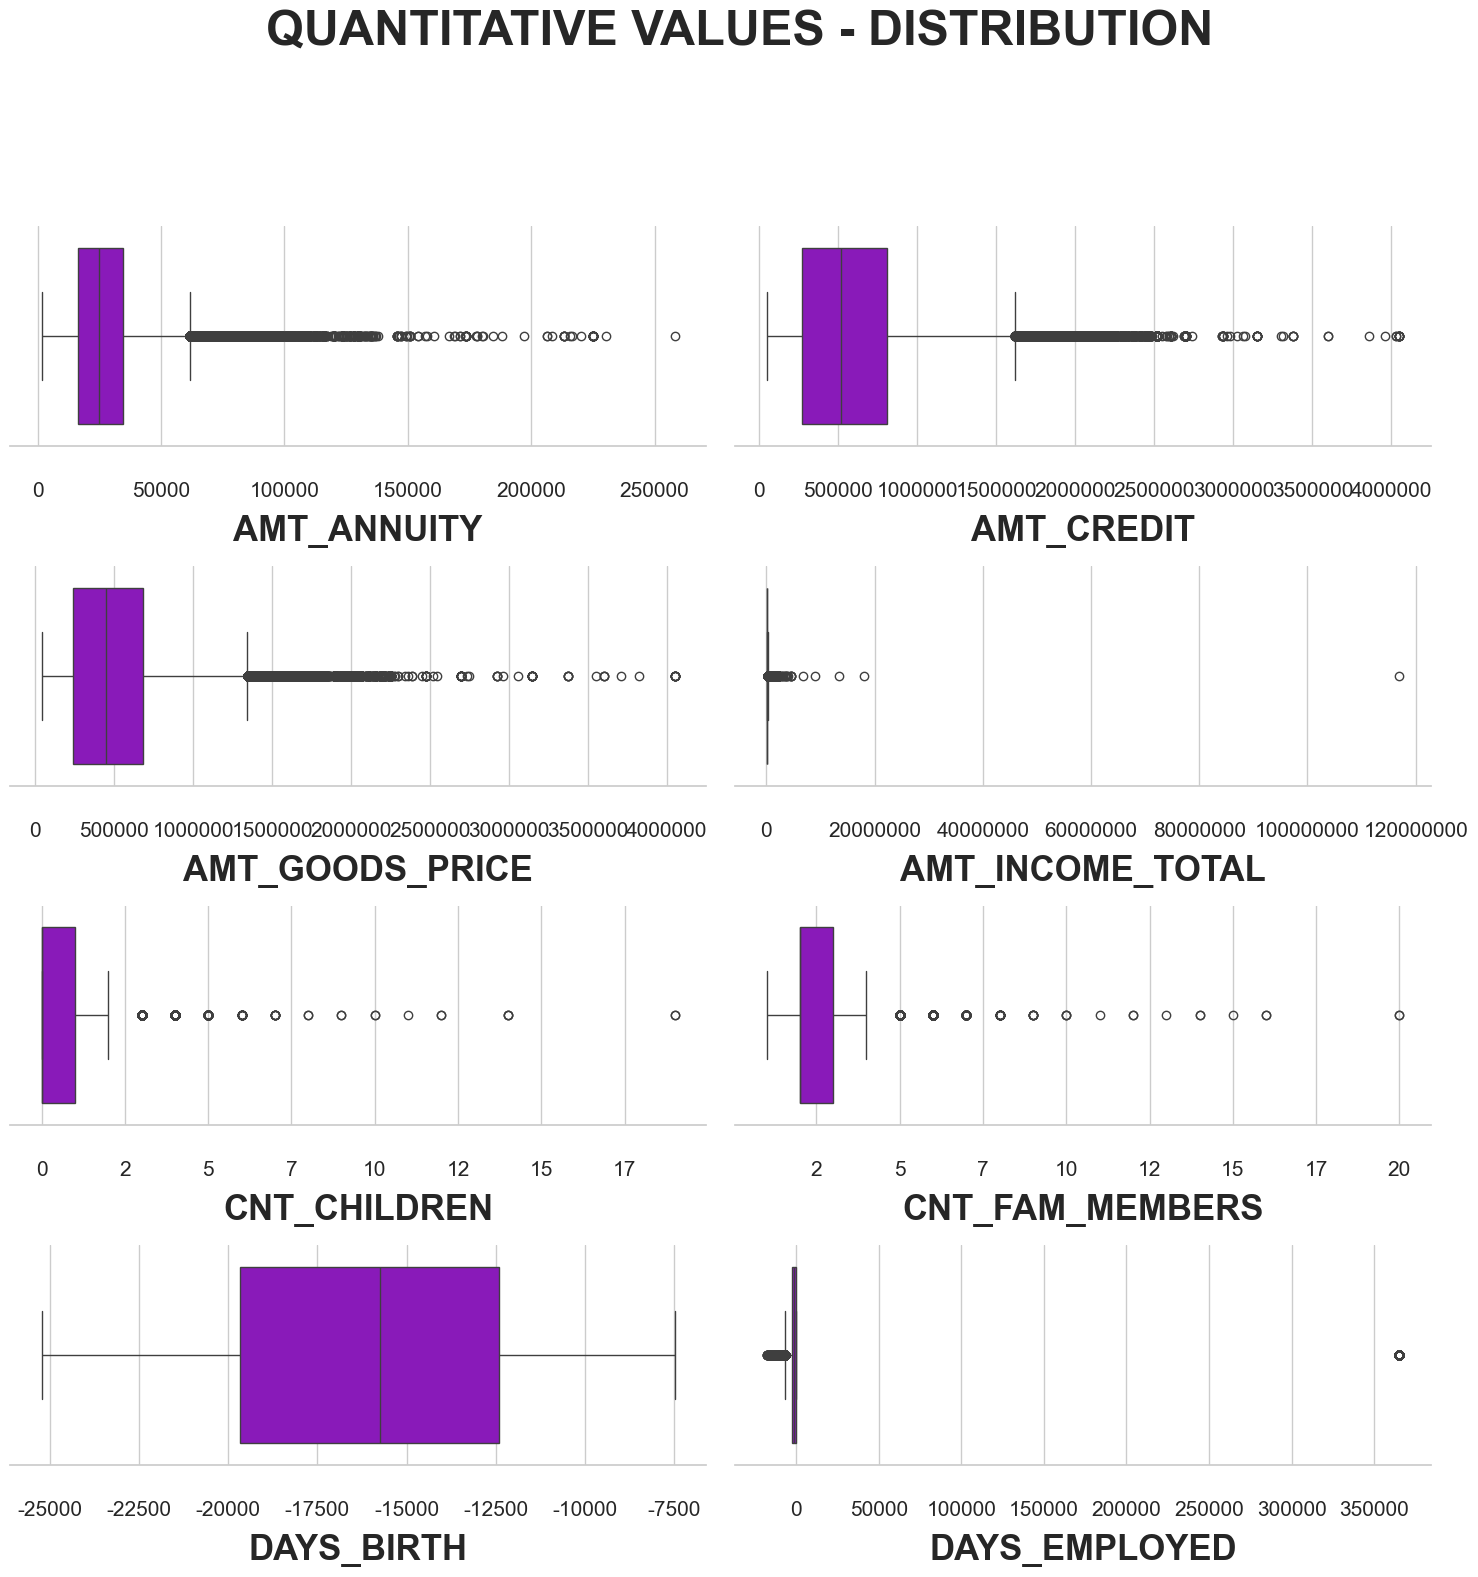

In [11]:
gf.plotBoxPlots(app_train[interesting_cols_quant], 15, 15, 4, 2)

An outlier clearly emerges from the graph presenting the DAYS_EMPLOYED distribution.

c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:352: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  b = sns.distplot(data[ind_quant], ax=ax, rug=True)
c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:354: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticks(), size = TICK_SIZE)
c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\gr

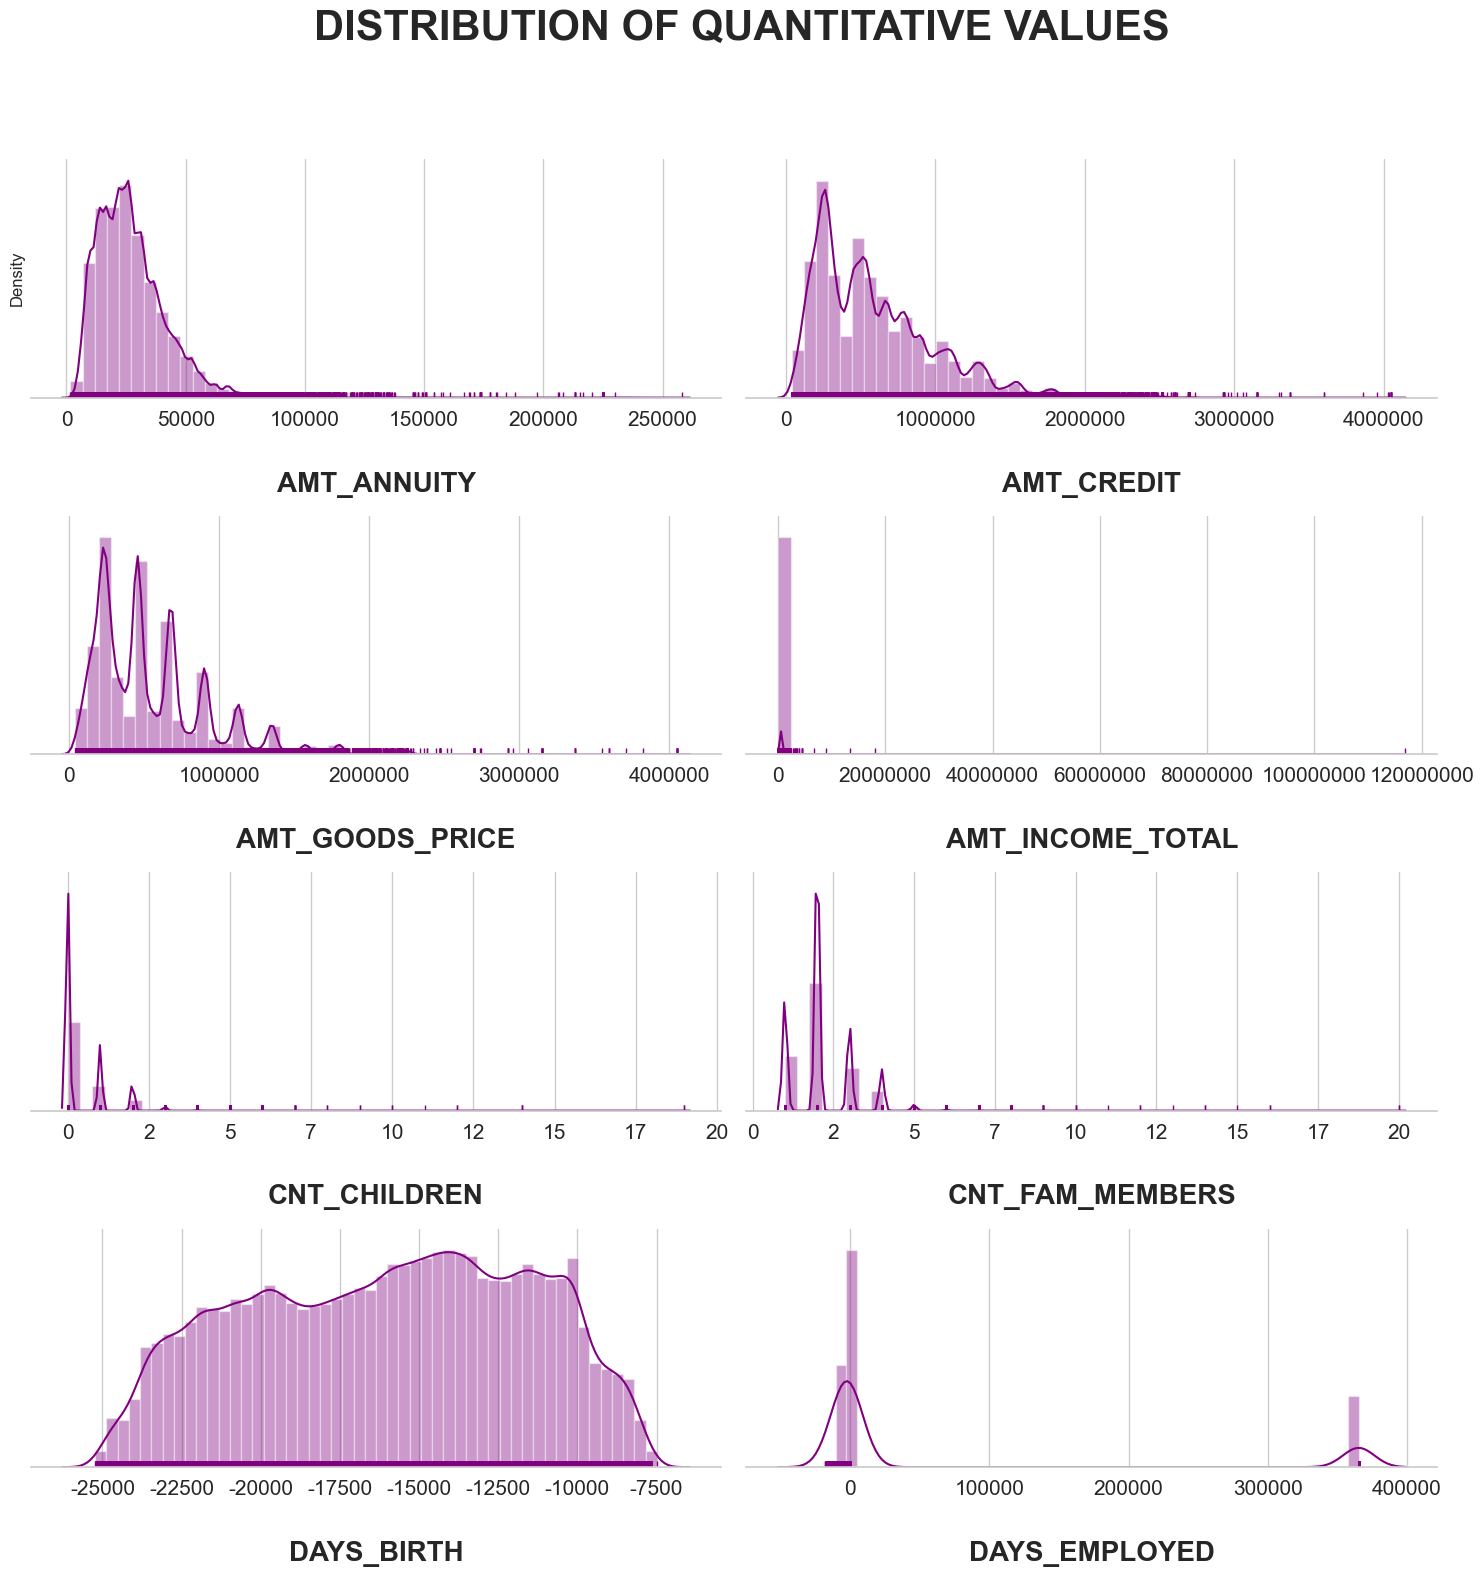

In [12]:
gf.plotDistplotsWithRug(app_train[interesting_cols_quant], 15, 15, 4, 2)

___
##### 1.2.2 _<u>Features qualitatives</u>_

In [13]:
gf.plot_qualitative_dist(app_train[interesting_cols_qual],
                         3, 3, 150, 150, "")

c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:446: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot_handle.set_xticklabels(plot_handle.get_xticks(), size=TICK_SIZE)
c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:449: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot_handle.set_yticklabels(yticks, size=TICK_SIZE, weight="bold")
c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:446: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot_handle.set_xticklabels(plot_handle.get_xticks(), size=TICK_S


___
##### 1.2.3 _<u>Loan repayment</u>_

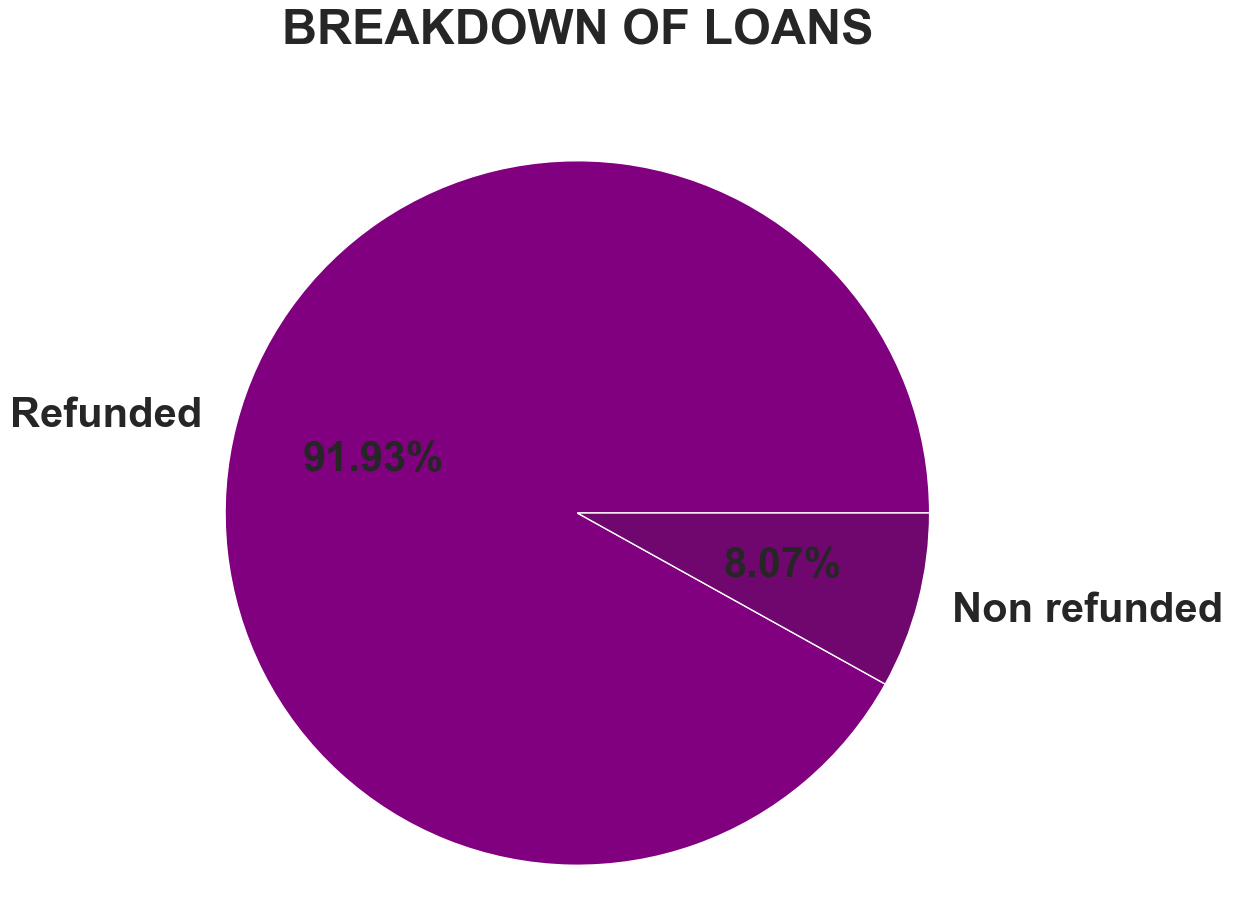

In [14]:
gf.plot_repartition(app_train["TARGET"].map(lambda x: "Refunded" if x==0 \
                                                     else "Non refunded"), 
                   "BREAKDOWN OF LOANS",
                   10, 10)

In dataset, a large majority of loans have been repaid. 
So this is a problem with a class imbalance. 
During the modeling stage, it will therefore be necessary to think about the methodology to use to obtain an efficient model.

___
#### 1.3 ANOMALIES

Let's take a closer look at the outliers spotted in DAYS_EMPLOYED.

In [15]:
print("The anomaly concerns {:2.2f}% of the data."\
.format(len(app_train[app_train['DAYS_EMPLOYED'] == 365243])/len(app_train)*100))

The anomaly concerns 18.01% of the data.


In [16]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('Standard customers do not repay %0.2f%% of credits.' % (100 * non_anom['TARGET'].mean()))
print('Customers affected by the anomaly do not reimburse %0.2f%% of the credits.'\
      % (100 * anom['TARGET'].mean()))

Standard customers do not repay 8.66% of credits.
Customers affected by the anomaly do not reimburse 5.40% of the credits.


For the study of correlations, we will simply replace the abnormal value with NaN.

In [17]:
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_26060\2142677179.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


___
#### 1.4 CORRELATIONS WITH TARGET DEFAULT RISK

___
##### 1.4.1 _<u>Strongest correlations</u>_

In [18]:
numeric_data = app_train.select_dtypes(include=[np.number])

correlations = numeric_data.corr("spearman").drop("TARGET", axis=0)['TARGET'].sort_values(ascending=False)

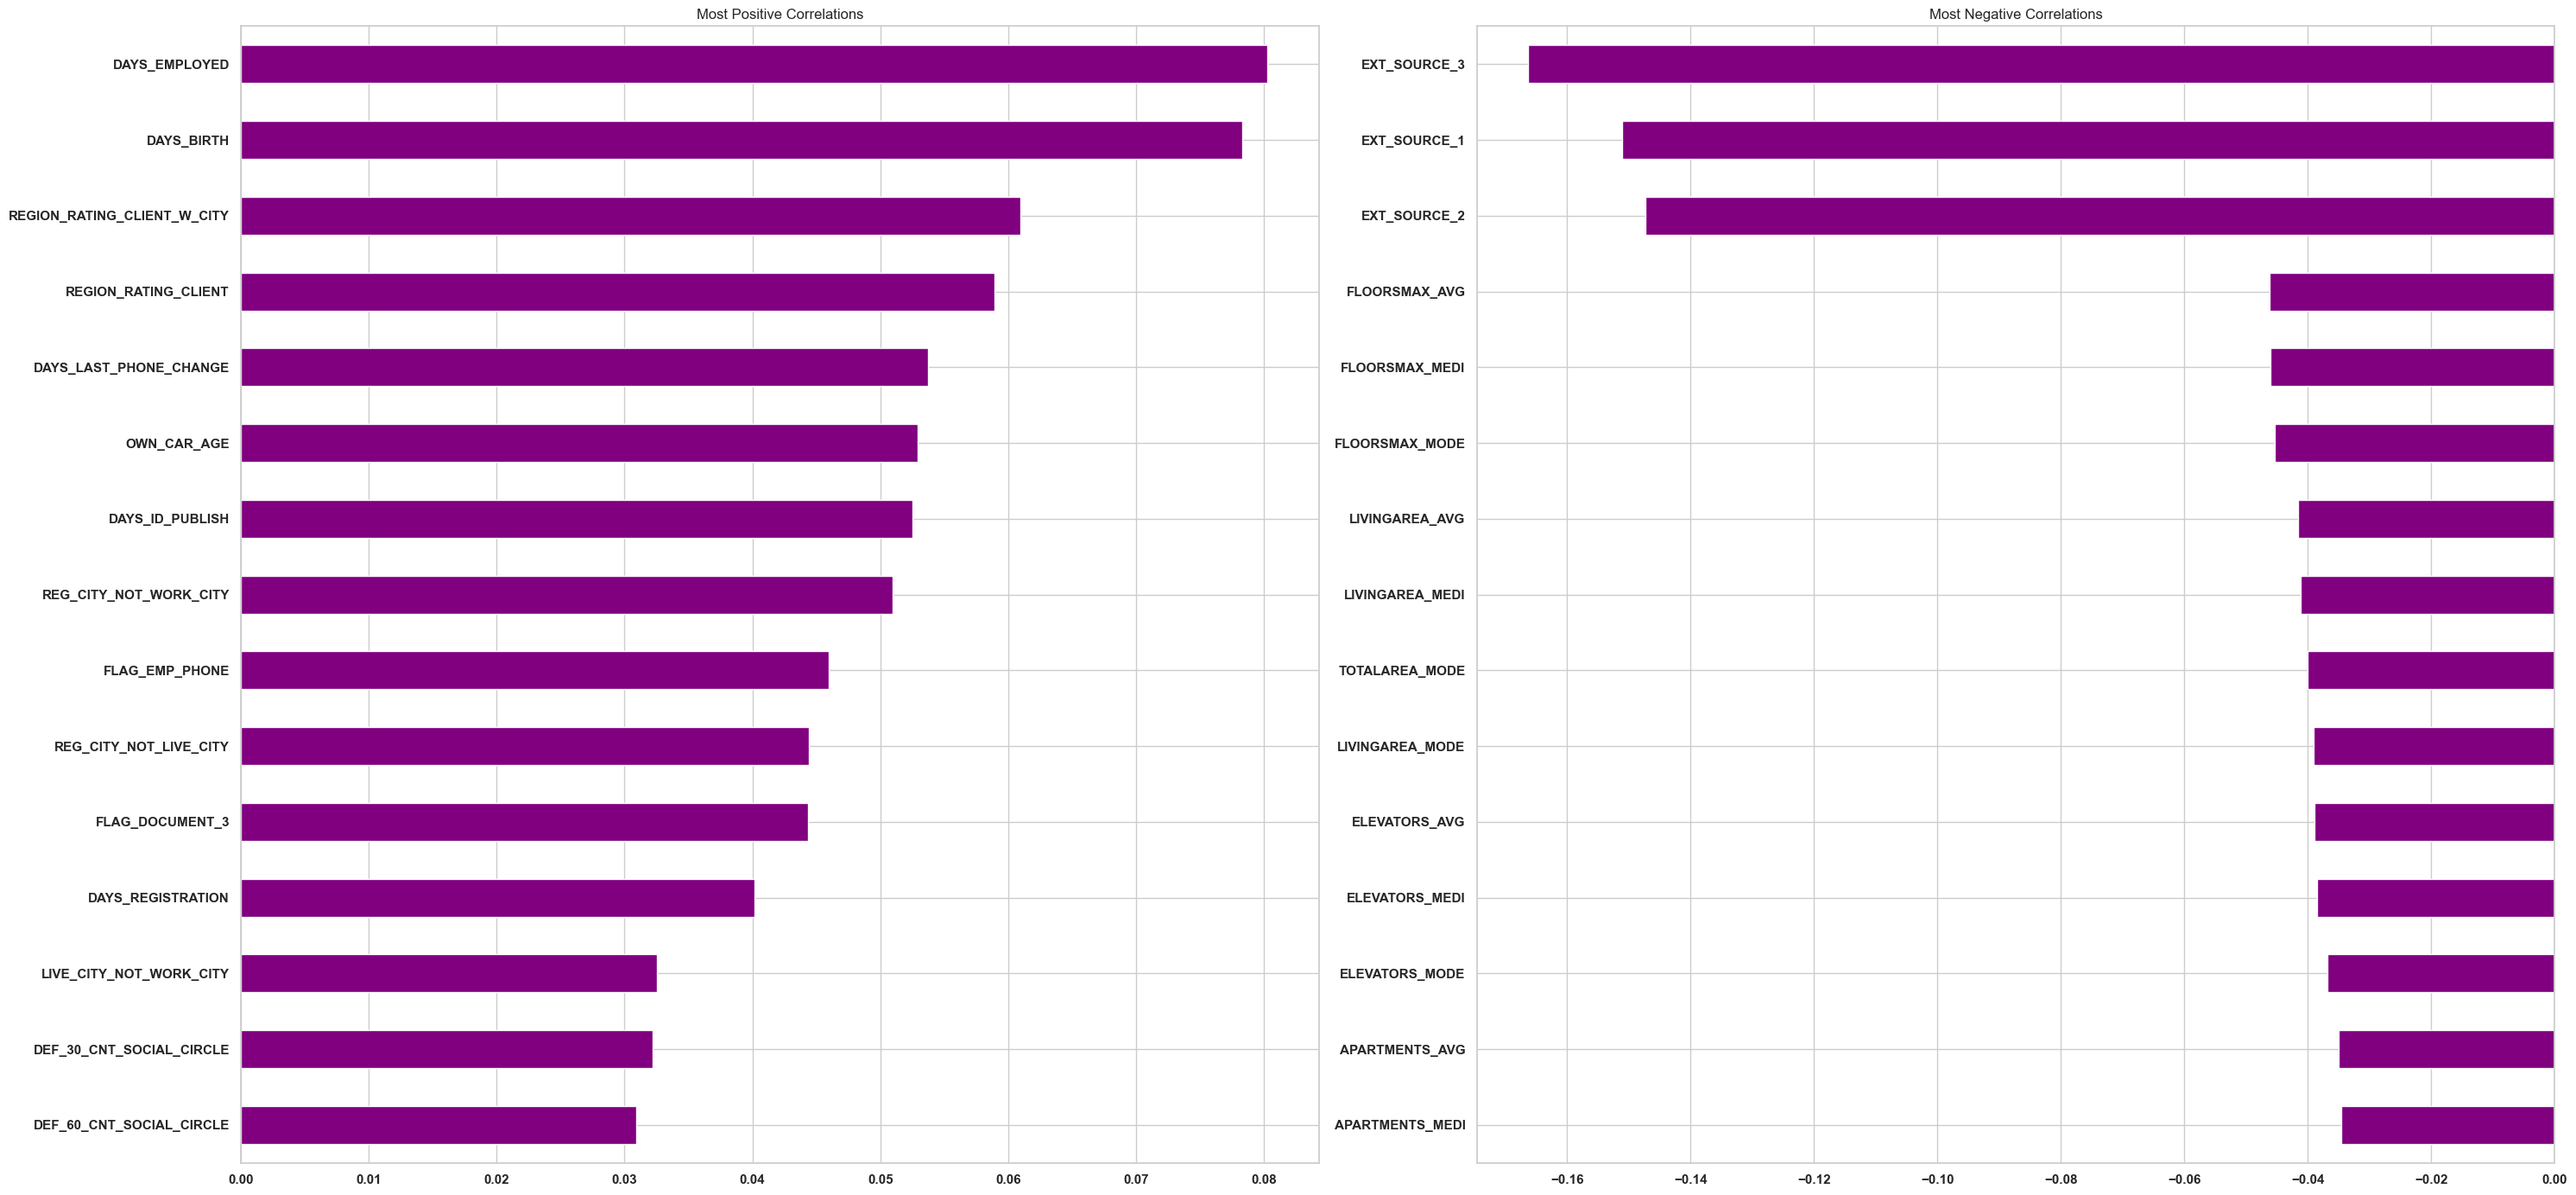

In [19]:
# Display correlations
fig, ax = plt.subplots(1,2, figsize=(30,14))
correlations.head(15).sort_values(ascending=True).plot.barh(ax = ax[0], 
                                                            title='Most Positive Correlations')
correlations.tail(15).plot.barh(ax = ax[1], 
                                title='Most Negative Correlations')
plt.tight_layout(h_pad = 2.5)

- The number of days of seniority and age have the strongest positive correlations with TARGET.
- Synthetic indicators have the strongest negative correlations with TARGET.

___
##### 1.4.2 _<u>Focus: correlation with seniority in current position DAYS_EMPLOYED</u>_

In [20]:
app_train["YEARS_EMPLOYED"] = app_train["DAYS_EMPLOYED"]/(-365)

In [21]:
# Age information into a separate dataframe
emploi_data = app_train[['TARGET', 'YEARS_EMPLOYED']].copy()

# Bin the age data
emploi_data['YEARS_EMPLOYED_BINNED'] = pd.cut(emploi_data['YEARS_EMPLOYED'], 
                                              bins = np.linspace(20, 70, num = 11))

# Group by the bin and calculate averages
emploi_groups  = emploi_data.groupby('YEARS_EMPLOYED_BINNED').mean()

C:\Users\Admin\AppData\Local\Temp\ipykernel_26060\177667802.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  emploi_groups  = emploi_data.groupby('YEARS_EMPLOYED_BINNED').mean()


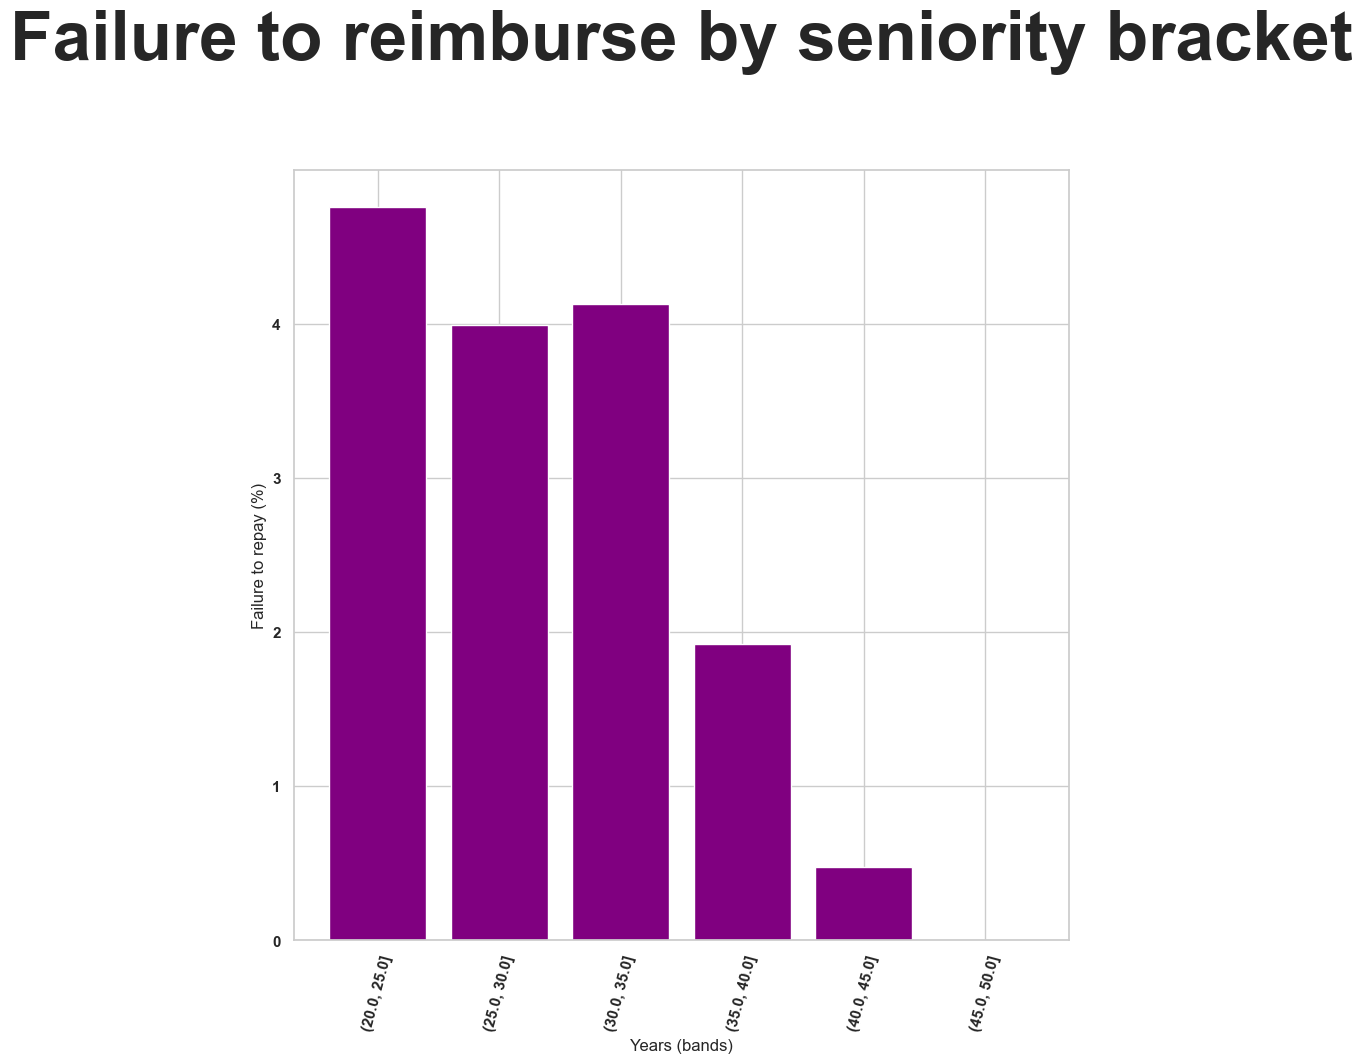

In [22]:
gf.plot_barplot(emploi_groups, 
                "TARGET", 
                "Failure to reimburse by seniority bracket", 
                10, 10)

We observe that from 35 years of seniority, the risk of payment default is divided by more than 2 compared to other employees with less seniority.

___
##### 1.4.3 _<u>Focus: correlation with age (DAYS_BIRTH)</u>_

In [23]:
app_train["AGE"] = app_train["DAYS_BIRTH"]/(-365)

c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:573: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_df[column],
c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:573: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_df[column],


<Figure size 640x480 with 0 Axes>

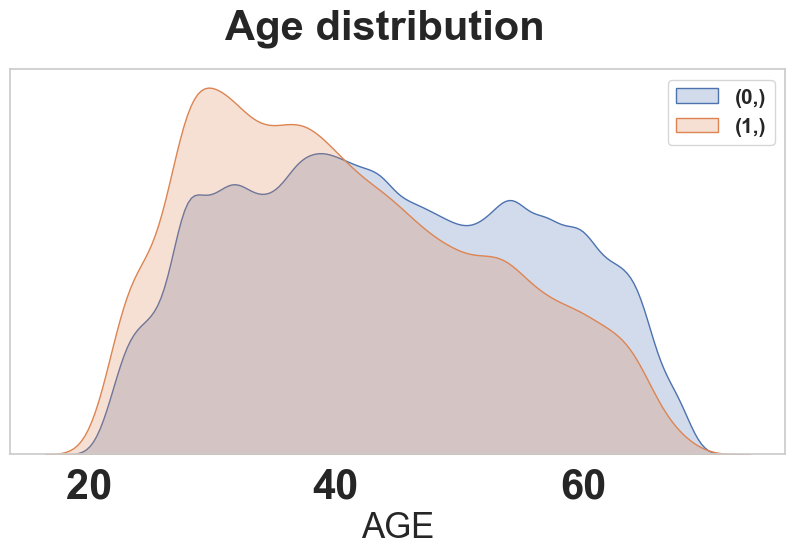

In [24]:
gf.plotKDE(app_train[["AGE", "TARGET"]], "AGE", "TARGET", 10, 5, "Age distribution")

In [25]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'AGE']].copy()

# Bin the age data
age_data['AGE_BINNED'] = pd.cut(age_data['AGE'], bins = np.linspace(20, 70, num = 11))

# Group by the bin and calculate averages
age_groups  = age_data.groupby('AGE_BINNED').mean()

C:\Users\Admin\AppData\Local\Temp\ipykernel_26060\2709866059.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_groups  = age_data.groupby('AGE_BINNED').mean()


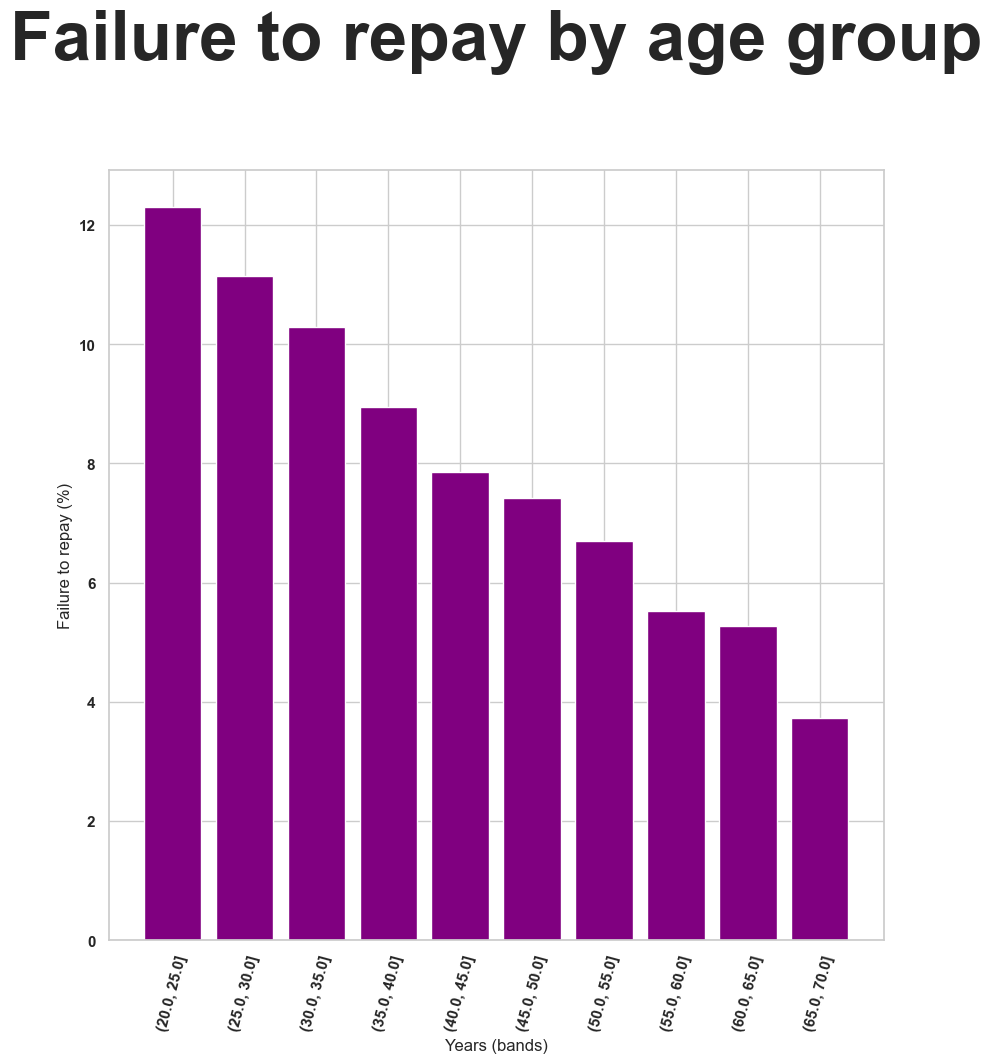

In [26]:
gf.plot_barplot(age_groups, 
                "TARGET", 
                "Failure to repay by age group", 
                10, 10)

The histogram by age group confirms our first observations: 
The repayment default rate is greater than 10% for the lowest age groups, and less than 5% for the three highest age groups.

___
##### 1.4.4 _<u>Focus: correlation with the synthetic indicators EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3</u>_

In [27]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 
                      'EXT_SOURCE_1', 
                      'EXT_SOURCE_2', 
                      'EXT_SOURCE_3', 
                      'DAYS_BIRTH']]

ext_data_corrs = ext_data.corr("spearman")

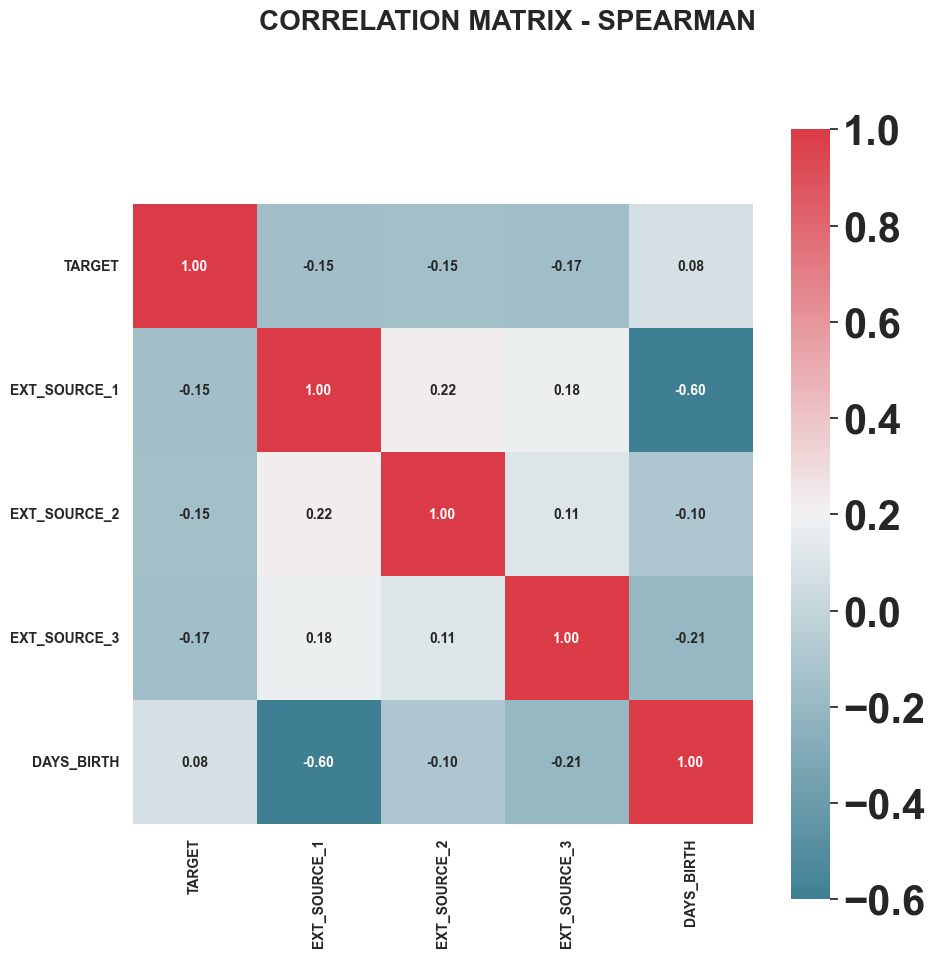

In [32]:
gf.plot_correlation_heatmap(ext_data_corrs, 10, 10)

We notice a strong negative correlation between age and EXT_SOURCE_1.

**EXT_SOURCE_1**

c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:573: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_df[column],
c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:573: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_df[column],


<Figure size 640x480 with 0 Axes>

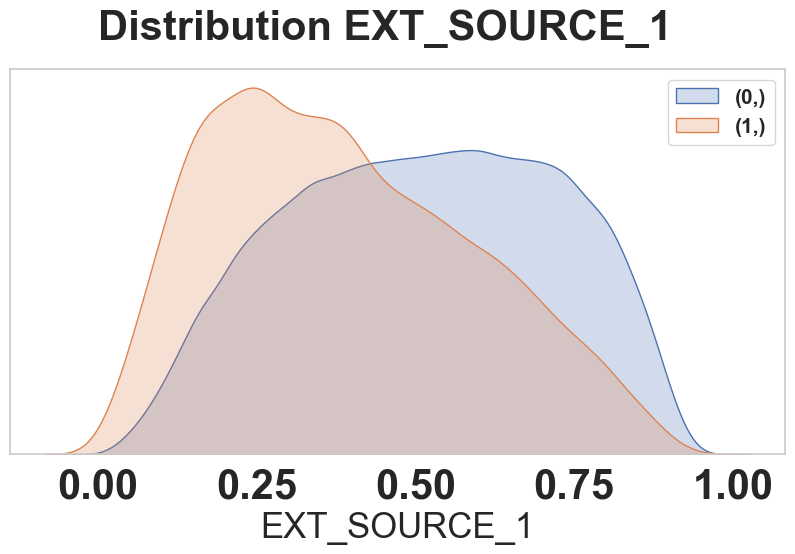

In [29]:
gf.plotKDE(app_train[["EXT_SOURCE_1", "TARGET"]], 
           "EXT_SOURCE_1", 
           "TARGET", 10, 5, 
           "Distribution EXT_SOURCE_1")

**EXT_SOURCE_2**

c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:573: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_df[column],
c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:573: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_df[column],


<Figure size 640x480 with 0 Axes>

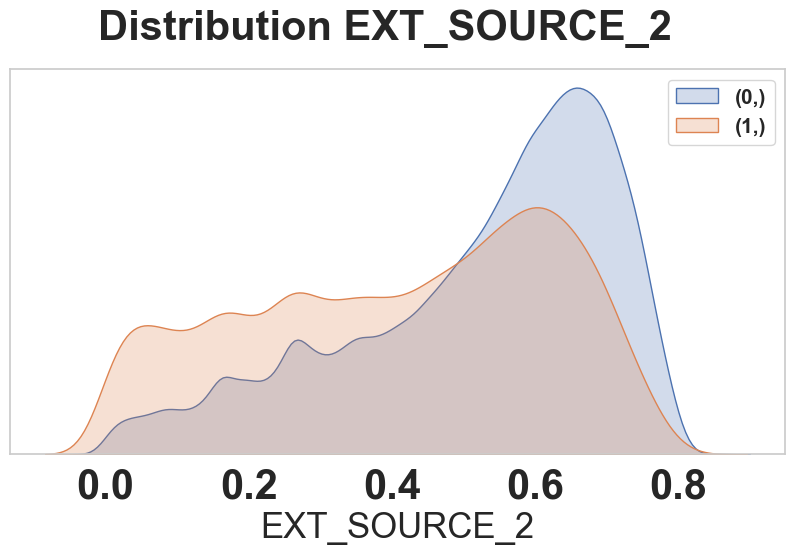

In [30]:
gf.plotKDE(app_train[["EXT_SOURCE_2", "TARGET"]], 
           "EXT_SOURCE_2", 
           "TARGET", 10, 5, 
           "Distribution EXT_SOURCE_2")

**EXT_SOURCE_3**

c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:573: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_df[column],
c:\Users\Admin\Desktop\credit_score_web_app-main\credit_score_data_modeling\Notebooks\./Resources/functions\graphical_functions.py:573: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_df[column],


<Figure size 640x480 with 0 Axes>

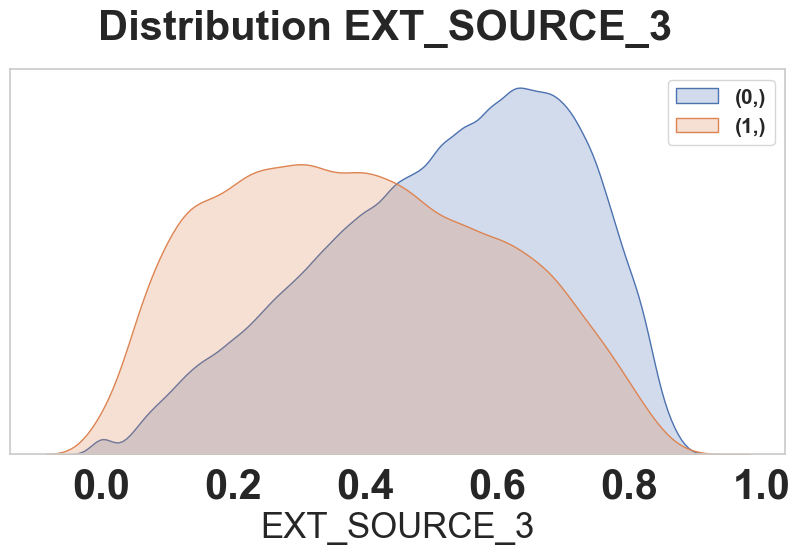

In [31]:
gf.plotKDE(app_train[["EXT_SOURCE_3", "TARGET"]], 
           "EXT_SOURCE_3", 
           "TARGET", 10, 5, 
           "Distribution EXT_SOURCE_3")

The variable EXT_SOURCE_3 presents the largest variations in its distribution between repaid/non-repaid loans.

___
### 2. Conclusion
___

The analysis was able to highlight several important information for future modeling:
- A third of the features in the dataset have 50% missing values.
- The number of days of employment of certain clients presents the same abnormal value
- correlations exist - although all generally weak - between the loan repayment rate and certain features of the dataset, in particular age, the number of days employed and the 3 synthetic indicators.